# ASTR-19 Group Tidal Report: Modeling and Statistical Analysis of Santa Cruz Tides

In this project we analyze real tidal measurements from Santa Cruz during January–February 2022.  
Our goals are to:

- Model the tides with an oscillatory function that captures both intra-day and inter-day variations.
- Fit this model to the data assuming a root mean squared (RMS) measurement uncertainty of 0.25 ft.
- Analyze the residuals to estimate the intrinsic scatter in the tides beyond measurement noise.
- Quantify how statistically unusual the January 14 tsunami (+2 ft water level) is in units of standard deviations ("sigma").
- Visualize the normal tidal variability and the tsunami event using histograms and time series plots.

## Section 1 — Load and Clean the Tidal Data

The data file `ASTR19_F25_group_project_data.txt` contains:

- Day number  
- Time of measurement in 24-hour `HH:MM` format  
- Tide height in feet  

We will:

1. Load the raw data using NumPy's `genfromtxt()`.  
2. Convert the day + time information into a single time variable `t` in units of **days since the first measurement**.  
3. Store the tide heights in an array `y` for further modeling and analysis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit #matplotlib for plotting scipy for tidal model

filename = "ASTR19_F25_group_project_data.txt"

raw = np.genfromtxt(
    filename,
    dtype=str,
    comments="#"
)

days = raw[:, 0].astype(float) #converts day and time into floats as well as height
time_strings = raw[:, 1]
heights = raw[:, 2].astype(float)

def hhmm_to_day_fraction(s):
    hh, mm = map(int, s.split(":"))
    return (hh + mm / 60.0) / 24.0

fractional_days = np.array([hhmm_to_day_fraction(ts) for ts in time_strings])

t = days + fractional_days
t = t - t.min()

y = heights
#total load 
print("Loaded", len(y), "data points.")
print("Time range (days):", t.min(), "to", t.max()) 

Loaded 82 data points.
Time range (days): 0.0 to 40.21319444444444


## Section 2 — Oscillatory Tidal Model and Best-Fit Curve

Tides in Santa Cruz show:

- A **semidiurnal cycle** (two highs and two lows per day, period ≈ 12.4 hours).
- A **daily modulation** that makes one high tide higher than the other and one low tide lower.

We model the tide height as a sum of two sinusoidal components plus a constant offset

where:
- \(T1 = 0.5175\) days ≈ 12.4 hours (semidiurnal cycle),  
- \(T2 = 1.0\) day (daily modulation),  
- (A1, A2, phi1, phi2, C) are fit parameters.

We fit this model using SciPy's `curve_fit()`, assuming an RMS measurement uncertainty of **0.25 ft**.

Best-fit parameters:
A1   = 1.019
phi1 = -0.059
A2   = -2.676
phi2 = 4.991
C    = 2.524


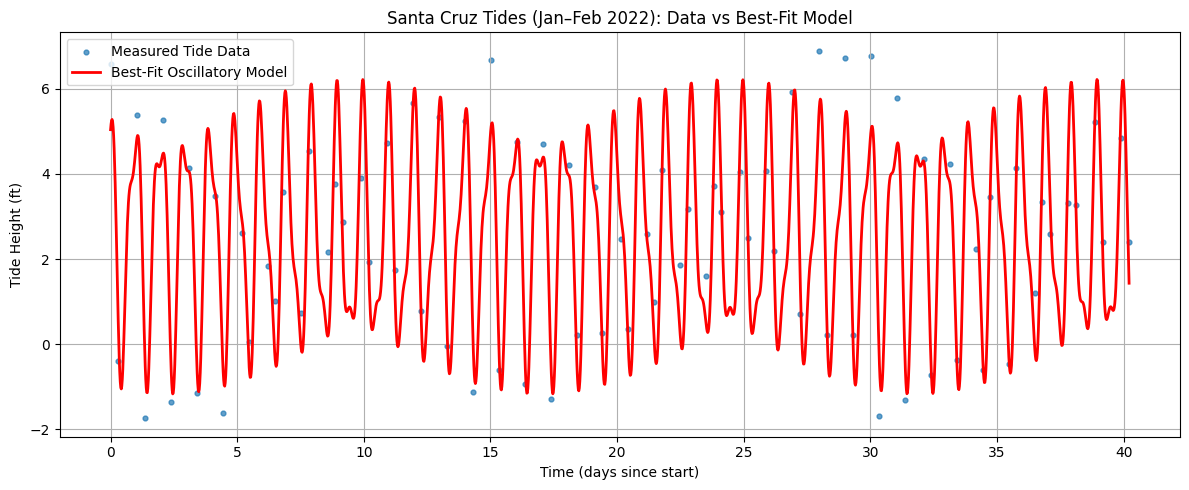

In [3]:
T1 = 0.5175
T2 = 1.0

def tide_model(t, A1, phi1, A2, phi2, C):
    return (
        A1 * np.sin(2 * np.pi * t / T1 + phi1) +
        A2 * np.sin(2 * np.pi * t / T2 + phi2) +
        C
    )
#used two tide components 24 hour as a day and 12.4 hours 
#tide model, curve fit which returns best fit amplitudes off set and and phases
sigma_meas = 0.25
sigma_array = np.full_like(y, sigma_meas)

initial_guess = [2.0, 0.0, 0.5, 0.0, np.mean(y)]

params, cov = curve_fit(
    tide_model,
    t,
    y,
    p0=initial_guess,
    sigma=sigma_array,
    absolute_sigma=True,
    maxfev=20000
)

A1_fit, phi1_fit, A2_fit, phi2_fit, C_fit = params

print("Best-fit parameters:")
print(f"A1   = {A1_fit:.3f}")
print(f"phi1 = {phi1_fit:.3f}")
print(f"A2   = {A2_fit:.3f}")
print(f"phi2 = {phi2_fit:.3f}")
print(f"C    = {C_fit:.3f}")
 
t_fit = np.linspace(t.min(), t.max(), 2000)
y_fit = tide_model(t_fit, *params)

plt.figure(figsize=(12, 5))
plt.scatter(t, y, s=12, alpha=0.7, label="Measured Tide Data")
plt.plot(t_fit, y_fit, "r-", linewidth=2, label="Best-Fit Oscillatory Model")

plt.xlabel("Time (days since start)")
plt.ylabel("Tide Height (ft)")
plt.title("Santa Cruz Tides (Jan–Feb 2022): Data vs Best-Fit Model")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("tide_fit_plot.pdf")
plt.show()

## Section 3 — Residuals, Scatter, and Intrinsic Variability

To evaluate how well the model describes the data, we analyze the **residuals**

We will:

- Plot residuals as a function of time to check for trends or unmodeled structure.  
- Compute the standard deviation of the residuals, sigma.  
- Compare sigma to the assumed measurement error sigma = 0.25.  
- Estimate the **intrinsic scatter** of the tides
  
Finally, we will plot a histogram of residuals and save it as a PDF.

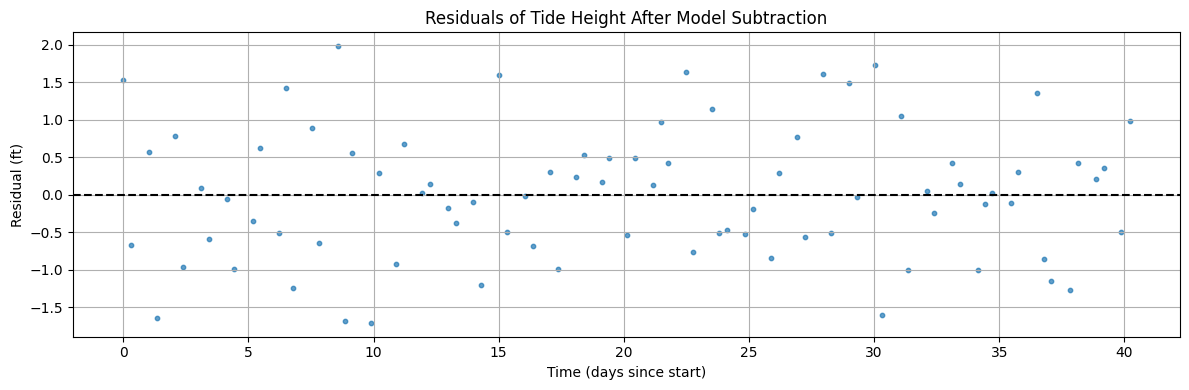

Total scatter of residuals (sigma_tot): 0.877 ft
Assumed measurement error (sigma_meas): 0.250 ft
Estimated intrinsic scatter (sigma_intrinsic): 0.840 ft


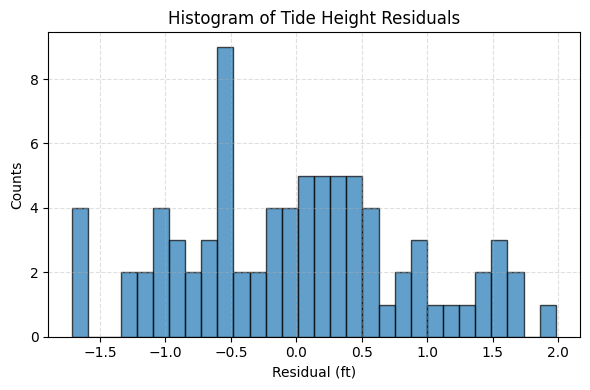

In [4]:
model_values = tide_model(t, *params)
residuals = y - model_values

plt.figure(figsize=(12, 4))
plt.scatter(t, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")

plt.xlabel("Time (days since start)")
plt.ylabel("Residual (ft)")
plt.title("Residuals of Tide Height After Model Subtraction")
plt.grid(True)

plt.tight_layout()
plt.savefig("tide_residuals_vs_time.pdf")
plt.show()

sigma_tot = np.std(residuals, ddof=1) #compares to measurment error 

print(f"Total scatter of residuals (sigma_tot): {sigma_tot:.3f} ft")
print(f"Assumed measurement error (sigma_meas): {sigma_meas:.3f} ft")

if sigma_tot > sigma_meas:
    sigma_intrinsic = np.sqrt(sigma_tot**2 - sigma_meas**2)  
else:
    sigma_intrinsic = 0.0

print(f"Estimated intrinsic scatter (sigma_intrinsic): {sigma_intrinsic:.3f} ft")

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Tide Height Residuals")
plt.grid(True, linestyle="--", alpha=0.4)
#it subtracts data with the model 
#shows the residual plot after the fitting 
plt.tight_layout()
plt.savefig("tide_residuals_histogram.pdf")
plt.show()

## Section 4 — Statistical Significance of the January 14 Tsunami

On January 14, 2022, a tsunami generated by the Hunga Tonga–Hunga Ha’apai eruption
increased the water level near high tide in Santa Cruz by approximately **2 ft**.

We want to:

1. Express this 2 ft increase in units of standard deviations ("sigma") relative to:  
   - The total residual scatter, sigma_tot  
   - The intrinsic scatter alone, sigma_intrinsic.  
2. Add a single +2 ft outlier to the residuals and replot the histogram to visualize
   how extreme this event is compared to normal tidal variability.

Tsunami significance relative to total scatter:     2.28 σ
Tsunami significance relative to intrinsic scatter: 2.38 σ


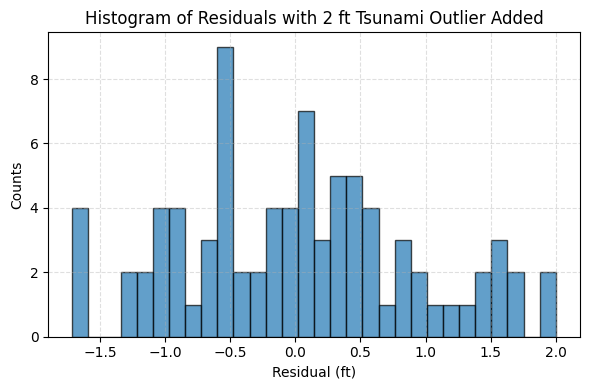

In [5]:
tsunami_height_increase = 2.0

N_sigma_tot = tsunami_height_increase / sigma_tot

if sigma_intrinsic > 0:
    N_sigma_intrinsic = tsunami_height_increase / sigma_intrinsic
else:
    N_sigma_intrinsic = np.inf
#adds tsunami as outlier 
#plot histogram along with the 2fft deviation 
print(f"Tsunami significance relative to total scatter:     {N_sigma_tot:.2f} σ")
print(f"Tsunami significance relative to intrinsic scatter: {N_sigma_intrinsic:.2f} σ")

residuals_with_outlier = np.append(residuals, tsunami_height_increase)

plt.figure(figsize=(6, 4))
plt.hist(residuals_with_outlier, bins=30, edgecolor="black", alpha=0.7)

plt.xlabel("Residual (ft)")
plt.ylabel("Counts")
plt.title("Histogram of Residuals with 2 ft Tsunami Outlier Added")
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("tide_residuals_histogram_with_tsunami.pdf")
plt.show()